<a href="https://colab.research.google.com/github/sundar-nallalagappan/Coursera_Timeseries/blob/main/Time_series_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
print("sairam")

sairam


In [23]:
import tensorflow as tf
print(tf.__version__)
import numpy as np

from tensorflow import keras
from keras.layers import Dense, Flatten

import matplotlib.pyplot as plt

2.12.0


In [24]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

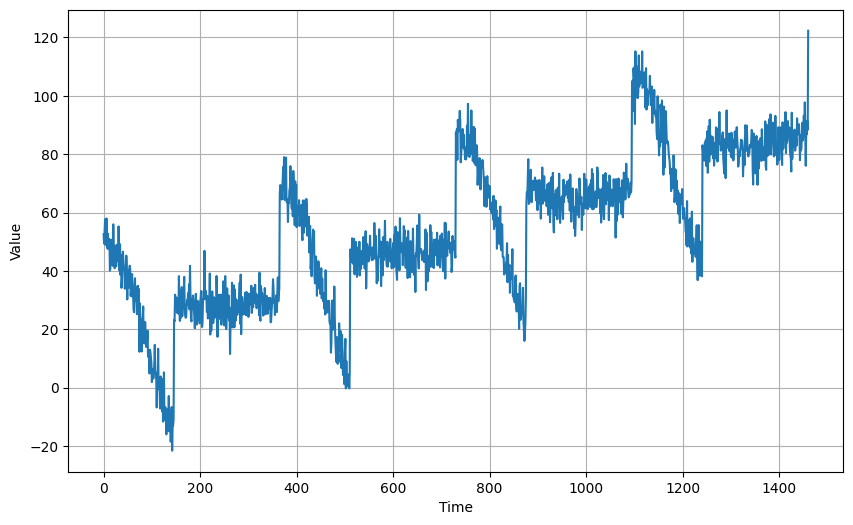

In [25]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [26]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

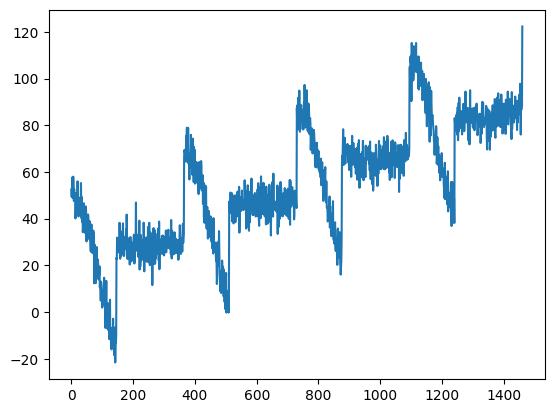

In [27]:
plt.plot(time, series)

# split dataset

In [28]:
SPLIT_TIME = 1000

time_train   = time[:SPLIT_TIME]
value_train  = series[:SPLIT_TIME]

time_valid   = time[SPLIT_TIME:]
value_valid  = series[SPLIT_TIME:]

print(time_train.shape, value_train.shape)
print(time_valid.shape, value_valid.shape)

(1000,) (1000,)
(461,) (461,)


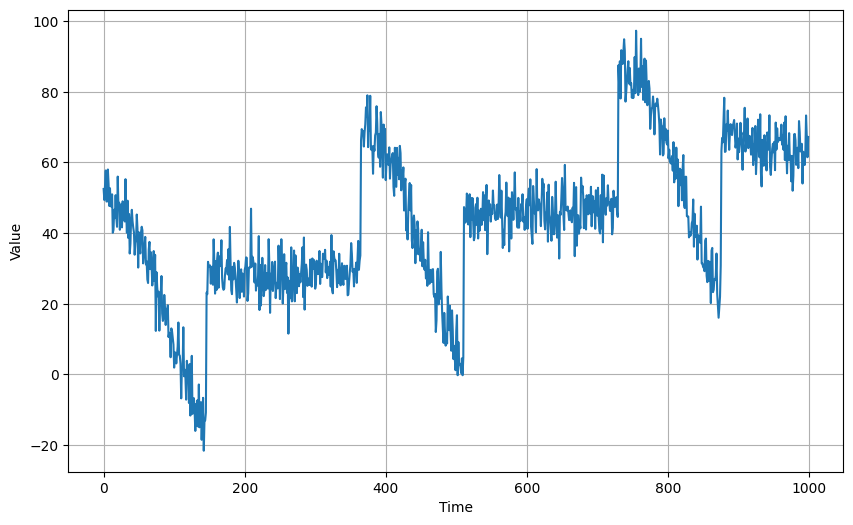

In [29]:
# Plot the results
plot_series(time_train, value_train)

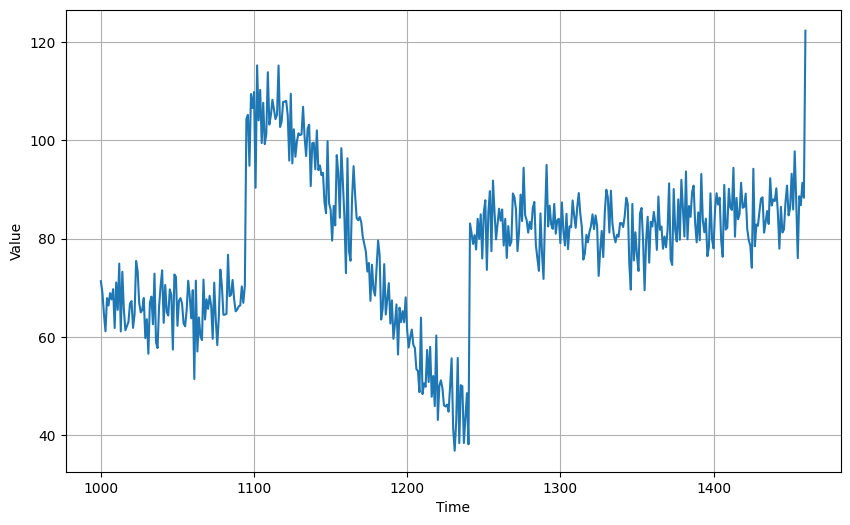

In [30]:
# Plot the results
plot_series(time_valid, value_valid)

# Prepare the window sized data - ready for NN training

In [31]:
window_size    = 30
shuffle_buffer = 100
batch_size     = 32

def window_sized_data(series, window_size, shuffle_buffer, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window : (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [32]:
value_train[0:10], value_train[-1]

(array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
        57.982895, 53.897125, 47.67393 , 52.68371 ], dtype=float32),
 67.19674)

In [33]:
ds = window_sized_data(value_train, window_size, shuffle_buffer, batch_size)
# Print the result
for window_dataset in ds:
  #print([item.numpy() for item in window_dataset])
  print(window_dataset)

Streaming output truncated to the last 5000 lines.
         26.50489   ,  21.541426  ,  35.955315  ,  20.655771  ,
         25.61978   ,  28.487524  ,  35.054302  ,  20.683037  ,
         33.692867  ,  27.943205  ,  22.999773  ,  30.233395  ,
         28.934015  ,  24.953756  ,  28.320253  ,  26.06135   ,
         28.57245   ,  31.332735  ,  35.969654  ,  21.868246  ,
         38.740505  ,  18.333178  ,  27.353228  ,  31.072536  ,
         29.55496   ,  25.05581   ],
       [ 30.233395  ,  28.934015  ,  24.953756  ,  28.320253  ,
         26.06135   ,  28.57245   ,  31.332735  ,  35.969654  ,
         21.868246  ,  38.740505  ,  18.333178  ,  27.353228  ,
         31.072536  ,  29.55496   ,  25.05581   ,  27.14825   ,
         25.743662  ,  25.281895  ,  32.497025  ,  30.054634  ,
         24.825788  ,  32.809357  ,  29.869114  ,  32.418423  ,
         31.52398   ,  24.252817  ,  25.619074  ,  32.178864  ,
         31.51689   ,  28.383394  ],
       [ 36.221428  ,  38.910835  ,  31.098

#  Build the model

In [76]:
model = keras.models.Sequential([
    Dense(10, input_shape=[window_size], activation="relu"),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              metrics=["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                310       
                                                                 
 dense_16 (Dense)            (None, 16)                176       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 503
Trainable params: 503
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(ds, epochs=100, verbose=2)

Epoch 1/100
31/31 - 1s - loss: 602.5672 - accuracy: 0.0000e+00 - 630ms/epoch - 20ms/step
Epoch 2/100
31/31 - 0s - loss: 156.9176 - accuracy: 0.0000e+00 - 181ms/epoch - 6ms/step
Epoch 3/100
31/31 - 0s - loss: 108.2680 - accuracy: 0.0000e+00 - 175ms/epoch - 6ms/step
Epoch 4/100
31/31 - 0s - loss: 89.4619 - accuracy: 0.0000e+00 - 226ms/epoch - 7ms/step
Epoch 5/100
31/31 - 0s - loss: 84.6466 - accuracy: 0.0000e+00 - 223ms/epoch - 7ms/step
Epoch 6/100
31/31 - 0s - loss: 79.7396 - accuracy: 0.0000e+00 - 219ms/epoch - 7ms/step
Epoch 7/100
31/31 - 0s - loss: 76.5234 - accuracy: 0.0000e+00 - 207ms/epoch - 7ms/step
Epoch 8/100
31/31 - 0s - loss: 73.4890 - accuracy: 0.0000e+00 - 118ms/epoch - 4ms/step
Epoch 9/100
31/31 - 0s - loss: 71.7943 - accuracy: 0.0000e+00 - 142ms/epoch - 5ms/step
Epoch 10/100
31/31 - 0s - loss: 70.7889 - accuracy: 0.0000e+00 - 118ms/epoch - 4ms/step
Epoch 11/100
31/31 - 0s - loss: 69.1552 - accuracy: 0.0000e+00 - 134ms/epoch - 4ms/step
Epoch 12/100
31/31 - 0s - loss: 68.42

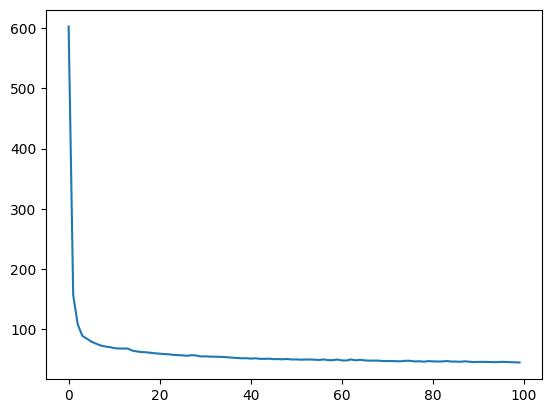

In [78]:
loss = history.history['loss']
epochs = range(100)

plt.plot(epochs, loss)

In [90]:
model.predict(value_valid[:window_size][np.newaxis])

1/1 [==============================] - 0s 119ms/step


array([[66.331085]], dtype=float32)

In [92]:
np.expand_dims(value_valid[:window_size], axis=0).shape

(1, 30)

In [93]:
model.predict(np.expand_dims(value_valid[:window_size], axis=0))

1/1 [==============================] - 0s 37ms/step


array([[66.331085]], dtype=float32)

In [98]:
series[SPLIT_TIME-window_size:].shape

(491,)

In [115]:
forecast[0:30].shape

(30,)

In [119]:
forecast = series[SPLIT_TIME - window_size:]
y_hat = []

for time in range(len(forecast) - window_size):
  #print(time)
  y_hat.append(model.predict(forecast[time: time + window_size][np.newaxis]))

1/1 [==============================] - 0s 26ms/step


In [135]:
results=np.array(y_hat).squeeze()
results.shape

(461,)

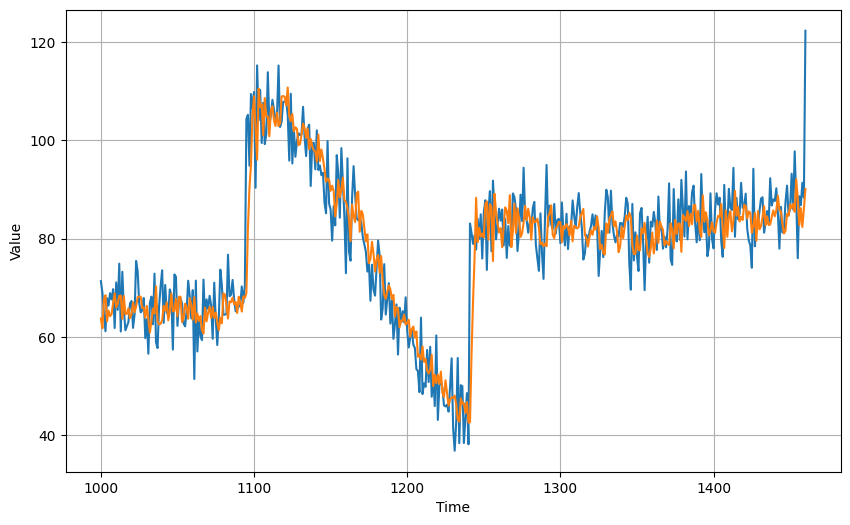

In [136]:
# Plot the results
plot_series(time_valid, (value_valid, results))

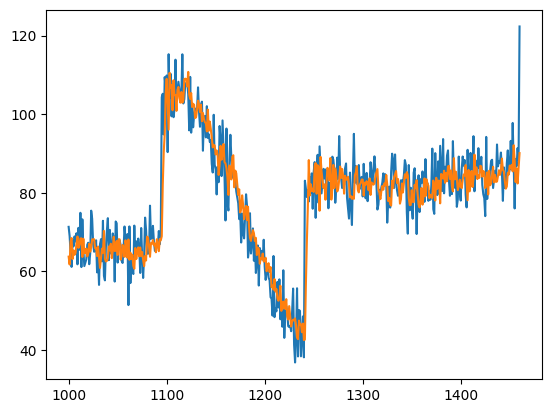

In [138]:
plt.plot(time_valid, value_valid)
plt.plot(time_valid, results)
plt.show()

Conv + LSTM

In [34]:
model = keras.models.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[window_size,1]),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*400.0)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mae"])

In [36]:
history = model.fit(ds,epochs=500)

Epoch 1/500
31/31 [==============================] - 7s 55ms/step - loss: 880.9274 - mae: 19.0857
Epoch 2/500
31/31 [==============================] - 1s 46ms/step - loss: 200.1344 - mae: 9.6372
Epoch 3/500
31/31 [==============================] - 2s 48ms/step - loss: 224.1721 - mae: 9.3756
Epoch 4/500
31/31 [==============================] - 1s 45ms/step - loss: 272.1826 - mae: 8.5802
Epoch 5/500
31/31 [==============================] - 1s 46ms/step - loss: 293.5410 - mae: 9.6397
Epoch 6/500
31/31 [==============================] - 1s 45ms/step - loss: 350.8482 - mae: 11.3467
Epoch 7/500
31/31 [==============================] - 2s 70ms/step - loss: 423.3235 - mae: 10.7522
Epoch 8/500
31/31 [==============================] - 2s 54ms/step - loss: 488.7142 - mae: 12.6420
Epoch 9/500
31/31 [==============================] - 2s 48ms/step - loss: 267.9415 - mae: 10.2611
Epoch 10/500
31/31 [==============================] - 1s 47ms/step - loss: 151.8069 - mae: 7.7160
Epoch 11/500
31/31 [====

In [37]:
forecast = series[SPLIT_TIME - window_size:]
y_hat = []

for time in range(len(forecast) - window_size):
  #print(time)
  y_hat.append(model.predict(forecast[time: time + window_size][np.newaxis]))

1/1 [==============================] - 0s 28ms/step


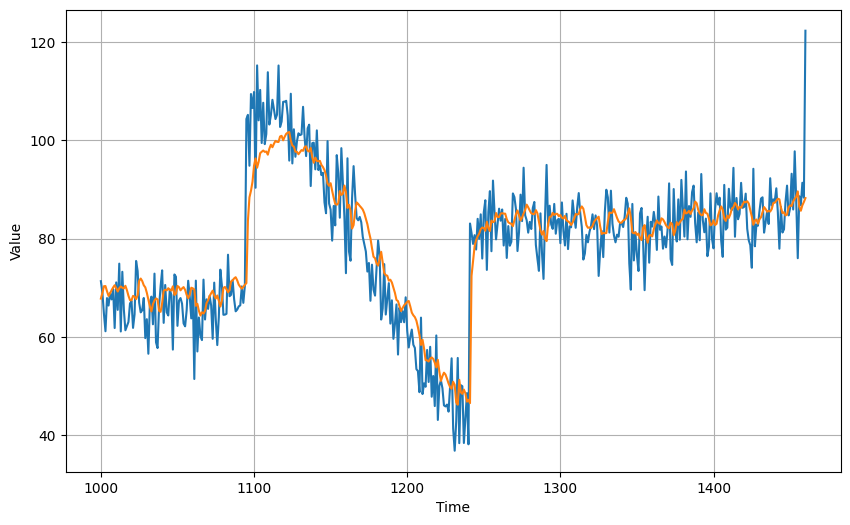

In [39]:
results=np.array(y_hat).squeeze()
results.shape
# Plot the results
plot_series(time_valid, (value_valid, results))

In [40]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(value_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(value_valid, results).numpy())

45.73768
5.1214867
